In [0]:
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from PIL import Image
import sys
from torchvision import transforms
import requests

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
img_size = 512

transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.CenterCrop(img_size),                                
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]), 
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1, 1, 1]),
                           transforms.Lambda(lambda x: x.mul_(255)),])

transform_for_show = transforms.Compose([transforms.Lambda(lambda x: x.clone()[0]),
                           transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]),
                           transforms.Lambda(lambda x: x.data.clamp(0, 1)),
                           transforms.ToPILImage()   
                           ])

In [0]:
content = Image.open('/content/gdrive/My Drive/Colab Notebooks/dog.jpg')
style = Image.open('/content/gdrive/My Drive/Colab Notebooks/points.jpg')


In [0]:
content = transform(content)
content = torch.unsqueeze(content, 0)
style = transform(style)
style = torch.unsqueeze(style, 0)

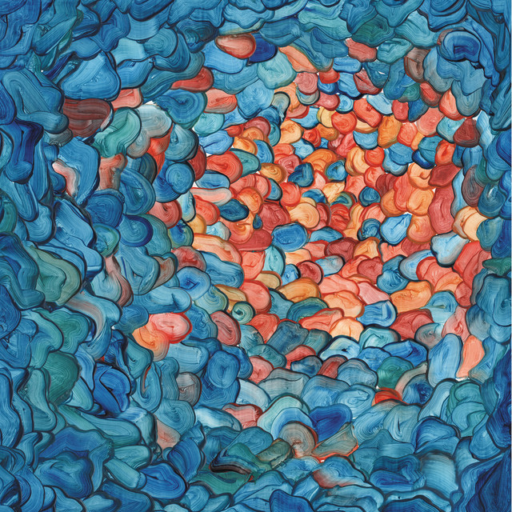

In [6]:
transform_for_show(style)

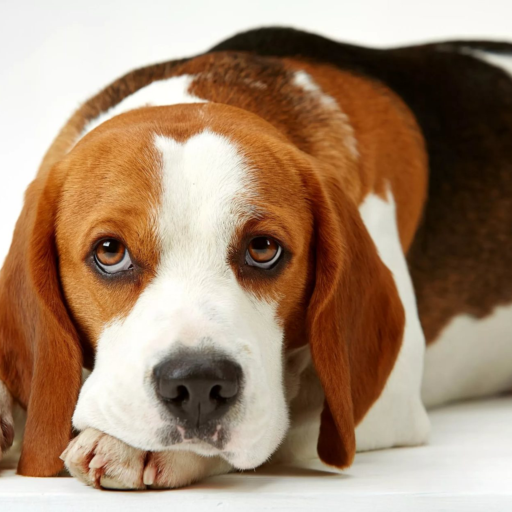

In [7]:
transform_for_show(content)

In [0]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = None

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


def gram_matrix(input):
    Nx, Cx, Hx, Wx = input.size()  
    features = input.view(Nx, Cx, Hx * Wx) 
    G = torch.bmm(features, features.transpose(1,2))
    G = G.div(Hx * Wx)
    return G

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = None

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    


In [0]:
class Artistic_style:
    def __init__(self, style_image, content_image, epoch,style_weight, content_weight):  
        self.style_image = style_image
        self.content_image = content_image
        self.target_image = Variable(content_image.data.clone(), requires_grad=True)
        self.epoch = epoch
        self.optimizer = optim.Adam([self.target_image], lr = 5)
        #self.optimizer = optim.LBFGS([self.target_image])
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.create_model()     
        
               
        

    def create_model(self):
        
        cnn = models.vgg19(pretrained=True).features.eval()
        style_layers = ['rele_1', 'relu_3', 'relu_5', 'relu_9', 'conv_12']
        content_layers = ['conv_10']  

        self.style_losses = []
        self.content_losses = []

        i = 0
        self.model = nn.Sequential()

        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
                #layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)


            self.model.add_module(name, layer)

            # Add style_loss 
            if name in style_layers:
                target_feature = self.model(self.style_image).detach()
                style_loss = StyleLoss(target_feature)
                self.model.add_module('style_loss_{}'.format(i), style_loss)
                self.style_losses.append(style_loss)


            # Add content_loss 
            if name in content_layers:
                target = self.model(self.content_image).detach()
                content_loss = ContentLoss(target)
                self.model.add_module('content_loss_{}'.format(i), content_loss)
                self.content_losses.append(content_loss)
                
        
    def train(self):

        for i in range(self.epoch):
            
            # Closure function is needed for LBFGS algorithm            
            def closure():

                self.optimizer.zero_grad()
                
                output = self.model(self.target_image)
                
                self.style_score = 0
                self.content_score = 0

                for j,s in enumerate(self.style_losses):
                    self.style_score += s.loss/self.style_weight[j]**2
                for j,c in enumerate(self.content_losses):
                    self.content_score += c.loss/self.content_weight[j]**2

                self.style_score *= 1e4
                self.content_score *= 1

                loss = self.content_score + self.style_score
                loss.backward()             

                return loss
            
            
            if (i % 200) == 0:             
                tr_im = transform_for_show(self.target_image)
                plt.figure(figsize=(15, 7))
                plt.imshow(tr_im)
                plt.show()
                

            self.optimizer.step(closure)
            if (i % 50) == 0:
                print(f'Run: {i+1}')
                print('Style Loss: {:4f} Content Loss: {:4f}'.format(self.style_score.item(), self.content_score.item()))
                print()
            

In [0]:
method = Artistic_style(style_image = style, content_image = content, epoch = 1000, style_weight = [64, 128, 256, 512, 512], content_weight = [1])

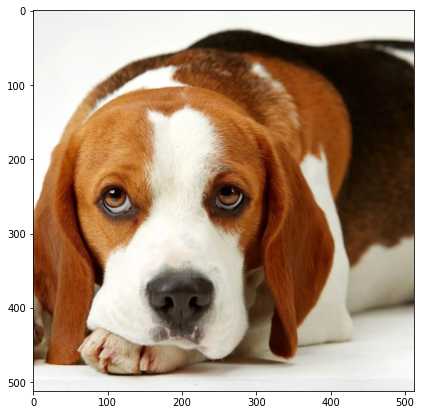

Run: 1
Style Loss: 298630560.000000 Content Loss: 0.000000

Run: 51
Style Loss: 14507292.000000 Content Loss: 236635.875000

Run: 101
Style Loss: 6524375.500000 Content Loss: 244439.578125

Run: 151
Style Loss: 4455830.500000 Content Loss: 242140.843750



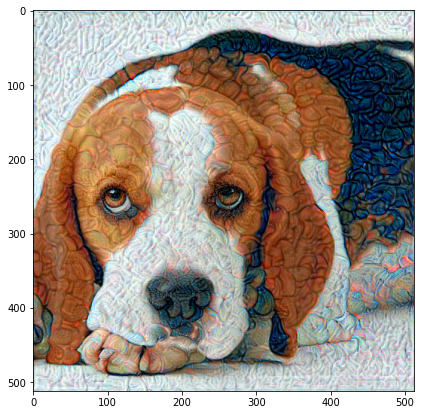

Run: 201
Style Loss: 3216934.500000 Content Loss: 243630.046875

Run: 251
Style Loss: 2369116.750000 Content Loss: 245165.140625

Run: 301
Style Loss: 1849487.750000 Content Loss: 246120.015625

Run: 351
Style Loss: 1686704.875000 Content Loss: 244886.156250



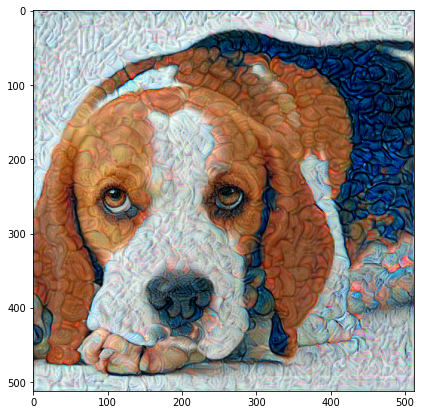

Run: 401
Style Loss: 1334743.500000 Content Loss: 245607.171875

Run: 451
Style Loss: 1122152.250000 Content Loss: 246552.718750

Run: 501
Style Loss: 13819735.000000 Content Loss: 245359.640625

Run: 551
Style Loss: 2741910.000000 Content Loss: 249086.375000



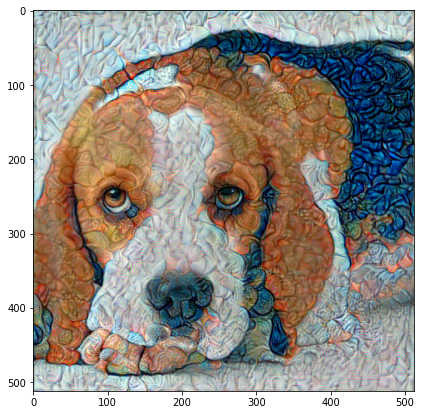

Run: 601
Style Loss: 1616451.750000 Content Loss: 246095.140625

Run: 651
Style Loss: 1174557.500000 Content Loss: 244811.281250

Run: 701
Style Loss: 929581.625000 Content Loss: 244122.718750

Run: 751
Style Loss: 780427.000000 Content Loss: 244080.828125



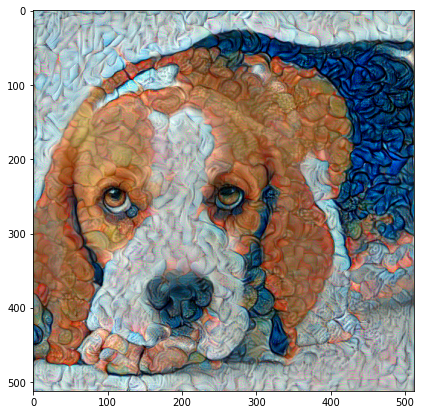

Run: 801
Style Loss: 932644.937500 Content Loss: 246947.281250

Run: 851
Style Loss: 610222.000000 Content Loss: 244173.906250

Run: 901
Style Loss: 505019.656250 Content Loss: 241745.921875

Run: 951
Style Loss: 462331.687500 Content Loss: 241027.562500



In [11]:
method.train()

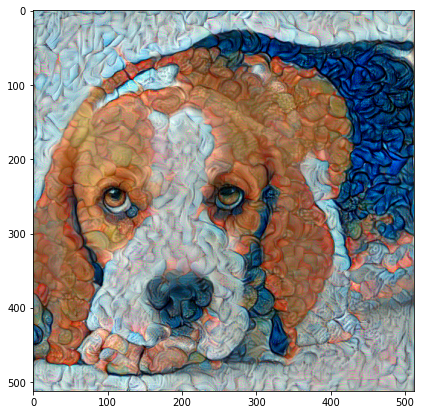

In [13]:
tr_im = transform_for_show(method.target_image)
plt.figure(figsize=(15,7))
plt.imshow(tr_im)
plt.show()